In [59]:
import h5py
import numpy as np
import keras
from keras.engine.topology import Layer, InputSpec
from keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, Flatten, Reshape, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.utils import multi_gpu_model
import matplotlib.pyplot as plt
%matplotlib inline
import random
from scipy.special import expit
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from keras.utils import multi_gpu_model
import tensorflow as tf

In [57]:
input_img=Input(shape= (40, 40, 1))
layer=input_img
layer=Conv2D(128, kernel_size=(3, 3),activation='relu',padding='same')(layer)
layer=MaxPooling2D(pool_size=(2, 2),padding='same')(layer)
layer=Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same')(layer)
layer=MaxPooling2D(pool_size=(2, 2),padding='same')(layer)
layer=Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same')(layer)

layer=Flatten()(layer)
layer=Dense(32, activation='relu')(layer)
layer=Dense(6, activation='relu')(layer)
layer=Dense(1, activation='sigmoid')(layer)

model=Model(input_img ,layer)
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam())
model.summary()
#model.load_weights(".h5")
model.save_weights('cnnbase.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 40, 40, 1)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 40, 40, 128)       1280      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 20, 20, 128)       147584    
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 10, 10, 128)       147584    
_________________________________________________________________
flatten_7 (Flatten)          (None, 12800)             0         
__________

In [70]:
# Not all NN model can benefit from the keras parallel (https://github.com/keras-team/keras/issues/9204)

GPU = 2
if GPU > 1:
    # Multi-GPU 
    parallel_model = multi_gpu_model(model, gpus=2)
    parallel_model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam())
    parallel_model.save_weights('parallel_cnnbase.h5')

In [13]:
f = h5py.File('/pub/daohangt/hep/data/all_118370.h5','r')
ee_x = f['features']['Ecal_E'][:]
et_x = f['features']['Ecal_ET'][:]
he_x = f['features']['Hcal_E'][:]
ht_x = f['features']['Hcal_ET'][:]
print(ee_x.shape)
print(et_x.shape)
print(he_x.shape)
print(ht_x.shape)

(236740, 31, 31)
(236740, 31, 31)
(236740, 32, 32)
(236740, 32, 32)


In [14]:
ee_y = f['targets']['Ecal_E'][:]
et_y = f['targets']['Ecal_ET'][:]
he_y = f['targets']['Hcal_E'][:]
ht_y = f['targets']['Hcal_ET'][:]
print(ee_y.shape)
print(et_y.shape)
print(he_y.shape)
print(ht_y.shape)

(236740,)
(236740,)
(236740,)
(236740,)


In [37]:
# Separate bg/sig for visualizing the jet images
ee_i_bg, ee_i_sig = np.where(ee_y == 0)[0], np.where(ee_y == 1)[0]
ee_x_bg = ee_x[ee_i_bg]
ee_x_sig = ee_x[ee_i_sig]

et_i_bg, et_i_sig = np.where(et_y == 0)[0], np.where(et_y == 1)[0]
et_x_bg = et_x[et_i_bg]
et_x_sig = et_x[et_i_sig]

he_i_bg, he_i_sig = np.where(he_y == 0)[0], np.where(he_y == 1)[0]
he_x_bg = he_x[he_i_bg]
he_x_sig = he_x[he_i_sig]

ht_i_bg, ht_i_sig = np.where(ht_y == 0)[0], np.where(ht_y == 1)[0]
ht_x_bg = ht_x[ht_i_bg]
ht_x_sig = ht_x[ht_i_sig]

In [35]:
# Visualize the bg and sig jet images
def plot2(a,b,vmax,name,ta,tb):
    fig = plt.figure(figsize=(10, 10))
    row,col=1,2
    ax1 = fig.add_subplot(row,col,1)
    plt.imshow(a,cmap='Blues',vmin=-10,vmax=vmax)
    ax2 = fig.add_subplot(row,col,2)
    plt.imshow(b,cmap='Reds',vmin=-10,vmax=vmax)
    #plt.show()
    ax1.title.set_text(ta)
    ax2.title.set_text(tb)
    plt.savefig(name)
    
def plot2_nAgg(s,e,xbg,xsig,vmax,name,ta,tb):
    if len(xbg.shape) == 3:
        xbgg = np.copy(xbg[0])
        xsigg = np.copy(xsig[0])
        for i in range(s,e):
            xbgg += xbg[i]
            xsigg += xsig[i]
    else:
        xbgg = np.copy(xbg[0][0])
        xsigg = np.copy(xsig[0][0])
        for i in range(s,e):
            xbgg += xbg[i][0]
            xsigg += xsig[i][0]
    plot2(xbgg,xsigg,vmax,name,ta,tb)

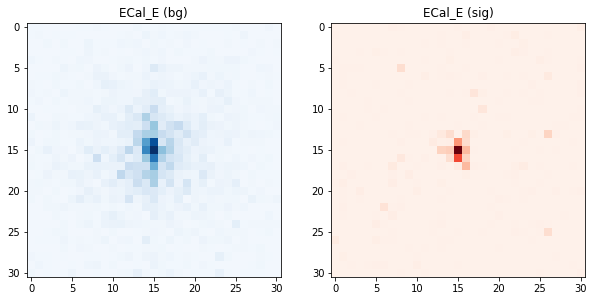

In [36]:
plot2_nAgg(0,1000,ee_x_bg,ee_x_sig,400,"ee.png",'ECal_E (bg)','ECal_E (sig)')

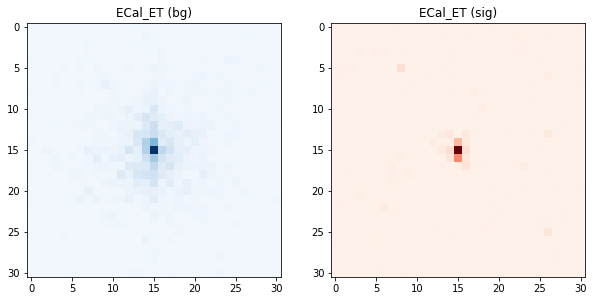

In [39]:
plot2_nAgg(0,1000,et_x_bg,et_x_sig,400,"et.png",'ECal_ET (bg)','ECal_ET (sig)')

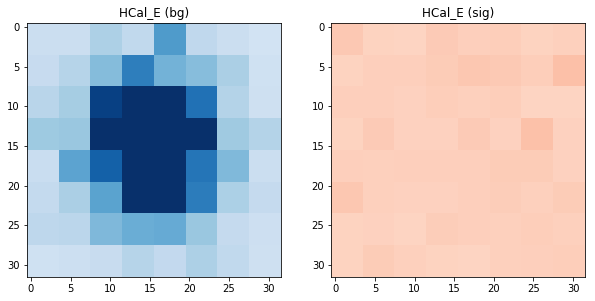

In [44]:
plot2_nAgg(0,1000,he_x_bg,he_x_sig,50,"he.png",'HCal_E (bg)','HCal_E (sig)')

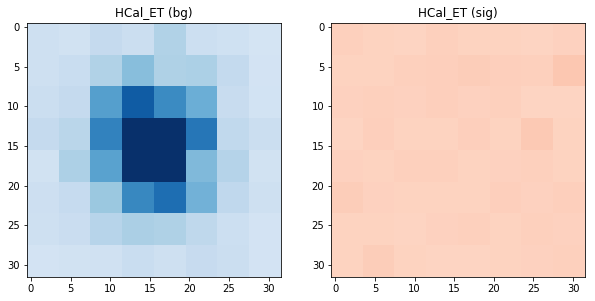

In [45]:
plot2_nAgg(0,1000,ht_x_bg,ht_x_sig,50,"ht.png",'HCal_ET (bg)','HCal_ET (sig)')

In [15]:
print("Before massaging: ")
print(ee_x.shape)
print(et_x.shape)
print(he_x.shape)
print(ht_x.shape)

def pad(x):
    if x.shape[-1] == 32:
        return np.pad(x,((0,0),(4,4),(4,4)), 'constant')
    else:
        # 31*31
        return np.pad(x,((0,0),(4,5),(4,5)), 'constant')

def extra(x):
    sz = x.shape+(1,)
    x = np.resize(x, tuple(i for i in sz))
    return x

# Massage the data: padding + extra1
ee_x = extra(pad(ee_x))
et_x = extra(pad(et_x))
he_x = extra(pad(he_x))
ht_x = extra(pad(ht_x))

print("After massaging: ")
print(ee_x.shape)
print(et_x.shape)
print(he_x.shape)
print(ht_x.shape)

Before massaging: 
(236740, 31, 31)
(236740, 31, 31)
(236740, 32, 32)
(236740, 32, 32)
After massaging: 
(236740, 40, 40, 1)
(236740, 40, 40, 1)
(236740, 40, 40, 1)
(236740, 40, 40, 1)


In [16]:
# Splitting train & validation & test
# train & validation is used for telling overfitting
# test is used for evaluating the model (AUC)
ee_x_tr, ee_x_te, ee_y_tr, ee_y_te = train_test_split(ee_x, ee_y, test_size=0.20, random_state=42)
et_x_tr, et_x_te, et_y_tr, et_y_te = train_test_split(et_x, et_y, test_size=0.20, random_state=42)
he_x_tr, he_x_te, he_y_tr, he_y_te = train_test_split(he_x, he_y, test_size=0.20, random_state=42)
ht_x_tr, ht_x_te, ht_y_tr, ht_y_te = train_test_split(ht_x, ht_y, test_size=0.20, random_state=42)

ee_x_tr, ee_x_val, ee_y_tr, ee_y_val = train_test_split(ee_x_tr, ee_y_tr, test_size=0.20, random_state=42)
et_x_tr, et_x_val, et_y_tr, et_y_val = train_test_split(et_x_tr, et_y_tr, test_size=0.20, random_state=42)
he_x_tr, he_x_val, he_y_tr, he_y_val = train_test_split(he_x_tr, he_y_tr, test_size=0.20, random_state=42)
ht_x_tr, ht_x_val, ht_y_tr, ht_y_val = train_test_split(ht_x_tr, ht_y_tr, test_size=0.20, random_state=42)

In [58]:
# Final check for the shape
def printShape(x):
    for i in x:
        print(i.shape)

printShape((ee_x_tr, ee_x_val, ee_x_te, ee_y_tr, ee_y_val, ee_y_te)) 
printShape((et_x_tr, et_x_val, et_x_te, et_y_tr, et_y_val, et_y_te))
printShape((he_x_tr, he_x_val, he_x_te, he_y_tr, he_y_val, he_y_te))
printShape((ht_x_tr, ht_x_val, ht_x_te, ht_y_tr, ht_y_val, ht_y_te))

(151513, 40, 40, 1)
(37879, 40, 40, 1)
(47348, 40, 40, 1)
(151513,)
(37879,)
(47348,)
(151513, 40, 40, 1)
(37879, 40, 40, 1)
(47348, 40, 40, 1)
(151513,)
(37879,)
(47348,)
(151513, 40, 40, 1)
(37879, 40, 40, 1)
(47348, 40, 40, 1)
(151513,)
(37879,)
(47348,)
(151513, 40, 40, 1)
(37879, 40, 40, 1)
(47348, 40, 40, 1)
(151513,)
(37879,)
(47348,)


In [60]:
data = {"ee":[ee_x_tr, ee_x_val, ee_x_te, ee_y_tr, ee_y_val, ee_y_te],
        "et":[et_x_tr, et_x_val, et_x_te, et_y_tr, et_y_val, et_y_te],
        "he":[he_x_tr, he_x_val, he_x_te, he_y_tr, he_y_val, he_y_te],
        "ht":[ht_x_tr, ht_x_val, ht_x_te, ht_y_tr, ht_y_val, ht_y_te]}

In [77]:
def plot_al(history,aorl,t):
    plt.plot(history.history[aorl])
    plt.plot(history.history['val_'+aorl])
    plt.title(t + (" Accuracy" if aorl=="acc" else " Loss"))
    plt.ylabel(aorl)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def roc(true,pred,t):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(true, pred)
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    print(roc_auc)
    plt.figure()
    plt.plot(fpr[1], tpr[1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(t + ' ROC')
    plt.show()
    plt.savefig(t+str(roc_auc[0])+".png")
    
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                           patience=5, verbose=0,
                                           mode='auto', baseline=None,
                                           restore_best_weights=True)]

In [78]:
def run_model(model, data, idx, p=False):
    lkup = {"ee":"ECal_E","et":"ECal_ET","he":"HCal_E","ht":"HCal_ET"}
    model.load_weights(('parallel_' if p else '') + 'cnnbase.h5')
    history = model.fit(data[idx][0], data[idx][3], epochs=20, batch_size=128, 
                    validation_data=(data[idx][1],data[idx][4]),verbose=1,
                    callbacks=callbacks)
    model.save_weights(('parallel_' if p else '') +'cnnbase_'+idx+'_20e_128b.h5')
    plot_al(history, 'loss', lkup[idx])
    y_hat = model.predict(data[idx][2])
    y_hat = np.reshape(y_hat,(y_hat.shape[0]))
    roc(data[idx][5], y_hat, lkup[idx])

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.1042 - val_loss: 0.0687
Epoch 2/20
151513/151513 [==============================] - 28s 186us/step - loss: 0.0709 - val_loss: 0.0667
Epoch 3/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.0689 - val_loss: 0.0652
Epoch 4/20
151513/151513 [==============================] - 28s 185us/step - loss: 0.0677 - val_loss: 0.0636
Epoch 5/20
151513/151513 [==============================] - 28s 185us/step - loss: 0.0664 - val_loss: 0.0640
Epoch 6/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.0660 - val_loss: 0.0689
Epoch 7/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.0649 - val_loss: 0.0748
Epoch 8/20
151513/151513 [==============================] - 28s 182us/step - loss: 0.0646 - val_loss: 0.0631
Epoch 9/20
151513/151513 [==============================] - 28s 185us/step - 

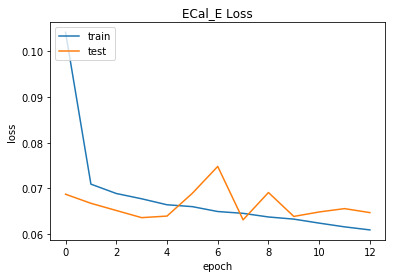

{0: 0.9969293707066418, 1: 0.9969293707066418}


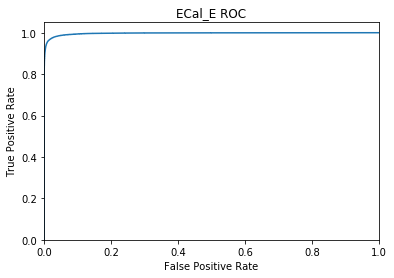

<Figure size 432x288 with 0 Axes>

In [80]:
run_model(model,data,"ee",p=False)

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 28s 186us/step - loss: 0.1853 - val_loss: 0.1131
Epoch 2/20
151513/151513 [==============================] - 28s 185us/step - loss: 0.0933 - val_loss: 0.0730
Epoch 3/20
151513/151513 [==============================] - 28s 185us/step - loss: 0.0583 - val_loss: 0.0387
Epoch 4/20
151513/151513 [==============================] - 28s 185us/step - loss: 0.0403 - val_loss: 0.0388
Epoch 5/20
151513/151513 [==============================] - 28s 185us/step - loss: 0.0392 - val_loss: 0.0396
Epoch 6/20
151513/151513 [==============================] - 28s 187us/step - loss: 0.0384 - val_loss: 0.0360
Epoch 7/20
151513/151513 [==============================] - 28s 186us/step - loss: 0.0376 - val_loss: 0.0407
Epoch 8/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.0376 - val_loss: 0.0425
Epoch 9/20
151513/151513 [==============================] - 28s 184us/step - 

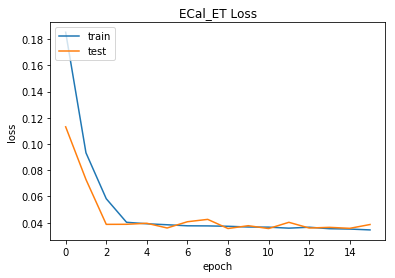

{0: 0.9985775723837182, 1: 0.9985775723837182}


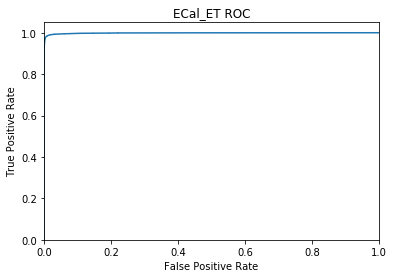

<Figure size 432x288 with 0 Axes>

In [81]:
run_model(model,data,"et",p=False)

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 28s 185us/step - loss: 0.3997 - val_loss: 0.3692
Epoch 2/20
151513/151513 [==============================] - 28s 186us/step - loss: 0.3697 - val_loss: 0.3649
Epoch 3/20
151513/151513 [==============================] - 28s 185us/step - loss: 0.3668 - val_loss: 0.3673
Epoch 4/20
151513/151513 [==============================] - 28s 185us/step - loss: 0.3659 - val_loss: 0.3624
Epoch 5/20
151513/151513 [==============================] - 28s 185us/step - loss: 0.3653 - val_loss: 0.3656
Epoch 6/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.3648 - val_loss: 0.3662
Epoch 7/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3640 - val_loss: 0.3637
Epoch 8/20
151513/151513 [==============================] - 28s 185us/step - loss: 0.3633 - val_loss: 0.3629
Epoch 9/20
151513/151513 [==============================] - 28s 186us/step - 

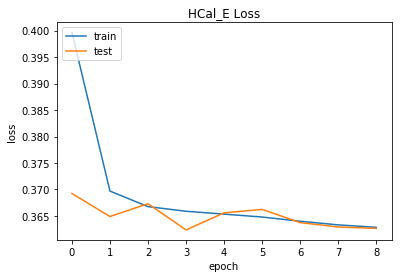

{0: 0.8901293180495814, 1: 0.8901293180495814}


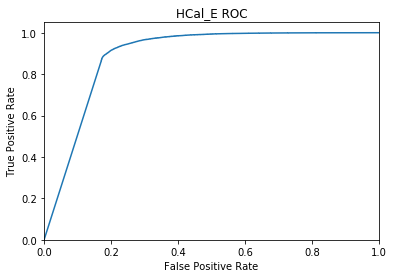

<Figure size 432x288 with 0 Axes>

In [82]:
run_model(model,data,"he",p=False)

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.3637 - val_loss: 0.3502
Epoch 2/20
151513/151513 [==============================] - 28s 187us/step - loss: 0.3538 - val_loss: 0.3529
Epoch 3/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.3534 - val_loss: 0.3508
Epoch 4/20
151513/151513 [==============================] - 28s 187us/step - loss: 0.3528 - val_loss: 0.3500
Epoch 5/20
151513/151513 [==============================] - 28s 187us/step - loss: 0.3526 - val_loss: 0.3512
Epoch 6/20
151513/151513 [==============================] - 28s 186us/step - loss: 0.3522 - val_loss: 0.3542
Epoch 7/20
151513/151513 [==============================] - 28s 185us/step - loss: 0.3520 - val_loss: 0.3507
Epoch 8/20
151513/151513 [==============================] - 28s 185us/step - loss: 0.3520 - val_loss: 0.3511
Epoch 9/20
151513/151513 [==============================] - 28s 185us/step - 

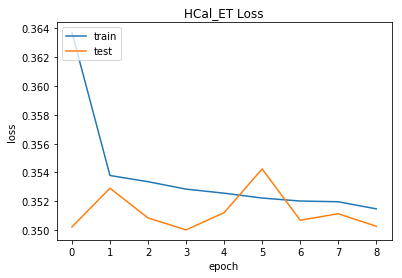

{0: 0.8926704744448425, 1: 0.8926704744448425}


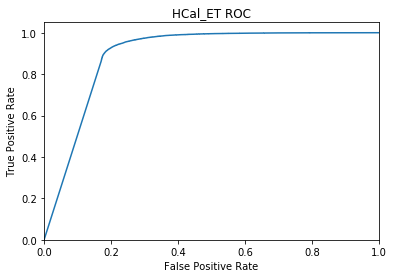

<Figure size 432x288 with 0 Axes>

In [83]:
run_model(model,data,"ht",p=False)